
dataset 0
---------
LogisticRegression: 0.86
LinearSVC: 0.88
KBinsDiscretizer + LogisticRegression: 0.94
KBinsDiscretizer + LinearSVC: 0.90
GradientBoostingClassifier: 0.90
SVC: 0.94

dataset 1
---------
LogisticRegression: 0.40
LinearSVC: 0.40
KBinsDiscretizer + LogisticRegression: 0.88
KBinsDiscretizer + LinearSVC: 0.64
GradientBoostingClassifier: 0.80
SVC: 0.84

dataset 2
---------
LogisticRegression: 0.96
LinearSVC: 0.98
KBinsDiscretizer + LogisticRegression: 0.94
KBinsDiscretizer + LinearSVC: 0.92
GradientBoostingClassifier: 0.94
SVC: 0.98


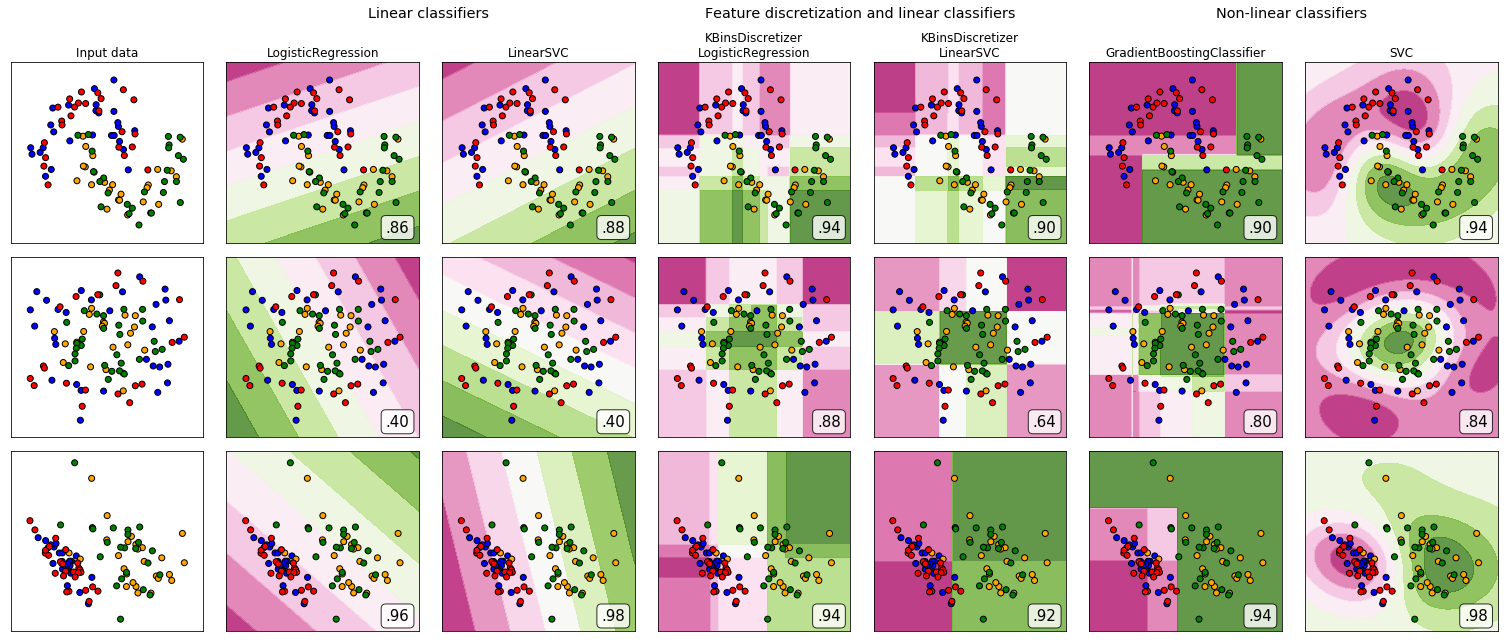

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

# import warnings
# warnings.filterwarnings("ignore")

h = .02
n_samples = 100  # 样本数量
cm = plt.cm.PiYG  # 决策边界颜色
# 蓝,红为一类点.橙,绿为一类点
# 蓝,橙为训练数据集.红绿为测试数据集
cm_bright_train = ListedColormap(['b', 'orange'])
cm_bright_test = ListedColormap(['red', 'green'])

# 所使用的数据集
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),  # Make two interleaving half circles
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    # Make a large circle containing a smaller circle in 2d
    make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                        n_informative=2, random_state=2,
                        n_clusters_per_class=1)  # Generate a random n-class classification problem
]

# 所使用的模型
classifiers = [
    # 逻辑回归
    (LogisticRegression(random_state=0, solver='lbfgs'), {
        'C': np.logspace(-2, 7, 10)  # 超参数C
    }),
    # 线性支持向量机
    (LinearSVC(random_state=0, tol=1e6), {
        'C': np.logspace(-2, 7, 10)
    }),
    (make_pipeline(
        KBinsDiscretizer(encode='onehot'),  # 离散型数据编码
        LogisticRegression(random_state=0, solver='lbfgs')), {
         'kbinsdiscretizer__n_bins': np.arange(2, 10),  # 超参数kbinsdiscretizer__n_bins
         'logisticregression__C': np.logspace(-2, 7, 10),
     }),
    (make_pipeline(
        KBinsDiscretizer(encode='onehot'), LinearSVC(random_state=0, tol=1e6)), {
         'kbinsdiscretizer__n_bins': np.arange(2, 10),
         'linearsvc__C': np.logspace(-2, 7, 10),
     }),
    # 梯度提升树
    (GradientBoostingClassifier(n_estimators=50, random_state=0), {
        'learning_rate': np.logspace(-4, 0, 10)
    }),
    (SVC(random_state=0, gamma='scale'), {
        'C': np.logspace(-2, 7, 10)
    }),
]


def get_name(estimator):
    """获取估计器名称"""
    name = estimator.__class__.__name__
    if name == 'Pipeline':
        name = [get_name(est[1]) for est in estimator.steps]
        name = ' + '.join(name)
    return name


names = [get_name(e) for e, g in classifiers]

fig, axes = plt.subplots(nrows=len(datasets), ncols=len(classifiers) + 1,
                         figsize=(21, 9))

for ds_cnt, (X, y) in enumerate(datasets):
    print('\ndataset %d\n---------' % ds_cnt)

    X = StandardScaler().fit_transform(X)  # 均值方差标准化
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright_train,
               edgecolors='k')  # 训练数据散点图
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright_test,
               edgecolors='k')  # 测试数据散点图
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())  # # 设置x轴刻度(刻度点,刻度值,网格线)不可见
    ax.set_yticks(())

    for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
        ax = axes[ds_cnt, est_idx + 1]

        clf = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)  # 超参数搜索(网格搜索)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)  # 不同模型通过超参数搜索(网格搜索)得到的最佳score
        print('%s: %.2f' % (name, score))

        if hasattr(clf, "decision_function"):  # decision_function:样本点到分类超平面的有符号距离
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)  # reshape是reval的反操作
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright_train,
                   edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright_test,
                   edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(name.replace(' + ', '\n'))
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0'), size=15,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'),
                transform=ax.transAxes, horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
suptitles = [
    'Linear classifiers',
    'Feature discretization and linear classifiers',
    'Non-linear classifiers',
]
for i, suptitle in zip([1, 3, 5], suptitles):
    ax = axes[0, i]
    ax.text(1.05, 1.25, suptitle, transform=ax.transAxes,
            horizontalalignment='center', size='x-large')
